Figure saved to: ../results/figures/fig6_dual_mode_heatmap_grouped.pdf
If the plot is still blank, please verify that the 'Theta' extraction matched the columns in your CSV.


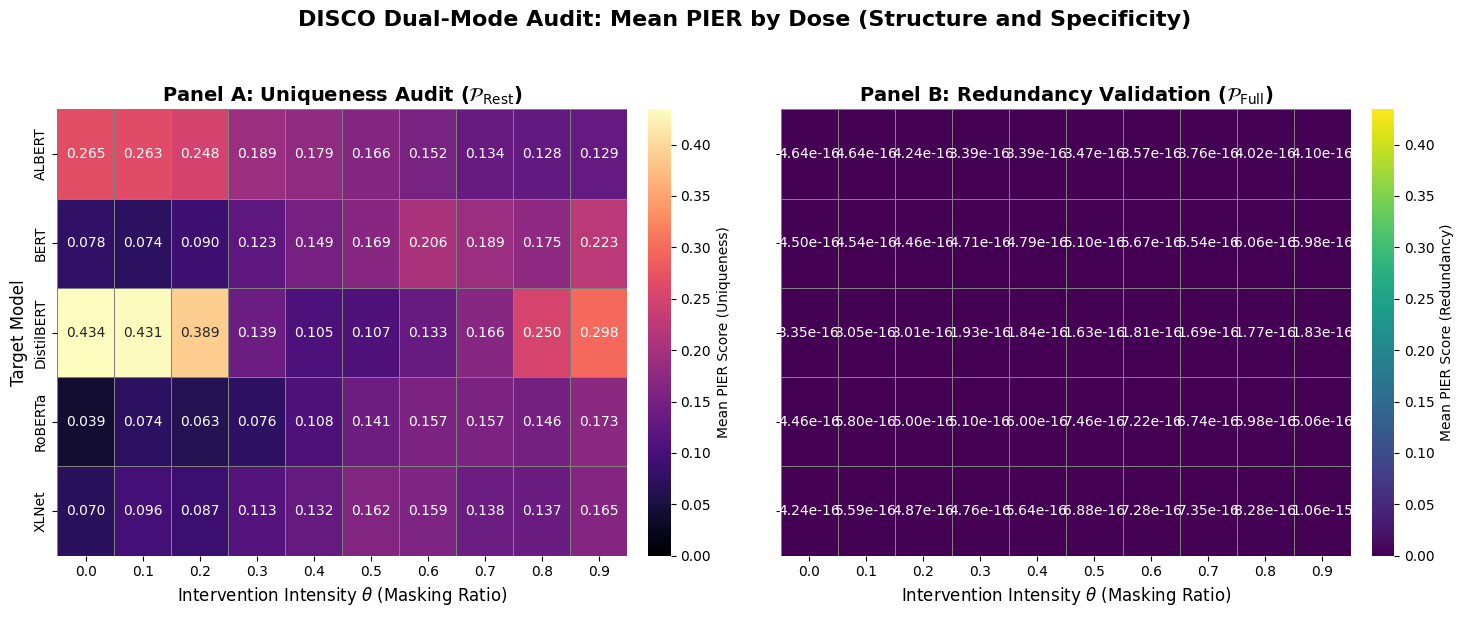

In [2]:
# notebooks/05_residual_heatmap_grouped.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load Data
DATA_PATH = "../results/tables/exp5_dual_mode_residuals.csv"
FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}. Please run experiments/exp5_dual_mode_audit.py first.")
    exit()
else:
    df_raw = pd.read_csv(DATA_PATH)

# --- Data Transformation and Aggregation ---

# 1. FIX: Robust Extraction of Numeric Theta from string 'Sample X $\theta=0.40$'
df_processed = df_raw.copy()
# Regex searches for the float number (e.g., 0.40) immediately following '='
# This is the most reliable way given the provided data structure.
df_processed['Theta'] = df_processed['Eval_Point'].str.extract(r'=([0-9\.]+)', expand=False).astype(float)
df_processed = df_processed.drop(columns=['Eval_Point'])


# 2. Convert to Long Format (Melt)
residual_cols = [col for col in df_processed.columns if '_R' in col]

df_melted = df_processed.melt(
    id_vars=['Theta'],
    value_vars=residual_cols,
    var_name='Target_Mode',
    value_name='Residual_Value'
)

# 3. Separate Target Name and Audit Mode Type
# Target_Mode is e.g., 'BERT_Uniqueness_R'
df_melted['Target_Name'] = df_melted['Target_Mode'].apply(lambda x: x.split('_')[0])
# Mode_Type becomes 'Uniqueness_R' or 'Redundancy_R'
df_melted['Mode_Type'] = df_melted['Target_Mode'].apply(lambda x: '_'.join(x.split('_')[1:])) 


# 4. Aggregate by (Theta, Target_Name, Mode_Type) to get Mean PIER (The core grouping step)
df_grouped = df_melted.groupby(['Theta', 'Target_Name', 'Mode_Type'])['Residual_Value'].mean().reset_index()


# 5. Pivot into Heatmap Matrices (Filtered by correct Mode_Type)
df_unique_pivot = df_grouped[df_grouped['Mode_Type'] == 'Uniqueness_R'].pivot(
    index='Target_Name', 
    columns='Theta', 
    values='Residual_Value'
).rename_axis(None, axis=1)

df_redundancy_pivot = df_grouped[df_grouped['Mode_Type'] == 'Redundancy_R'].pivot(
    index='Target_Name', 
    columns='Theta', 
    values='Residual_Value'
).rename_axis(None, axis=1)


# 6. Apply Sorting for Better Visualization
sort_order = ["RoBERTa", "XLNet", "ALBERT", "DistilBERT", "BERT"]
sort_indices = df_unique_pivot.index.intersection(sort_order)
df_unique_pivot = df_unique_pivot.loc[sort_indices]
df_redundancy_pivot = df_redundancy_pivot.loc[sort_indices]


# --- Visualization: Side-by-Side Heatmaps ---

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Define common scale and fix the ValueError calculation
v_max = max(np.nanmax(df_unique_pivot.values) if not df_unique_pivot.empty else 0.0, 0.25)


# 1. Plot Unique Audit (Sensitivity)
sns.heatmap(
    df_unique_pivot, 
    ax=axes[0], 
    cmap="magma", 
    annot=True,
    fmt=".3f", 
    vmin=0, 
    vmax=v_max, 
    cbar_kws={'label': 'Mean PIER Score (Uniqueness)', 'pad': 0.03},
    linewidths=0.5,
    linecolor='gray'
)
axes[0].set_title(r'Panel A: Uniqueness Audit ($\mathcal{P}_{\text{Rest}}$)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Target Model', fontsize=12)
axes[0].set_xlabel(r'Intervention Intensity $\theta$ (Masking Ratio)', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)

# 2. Plot Redundancy Validation (Specificity)
sns.heatmap(
    df_redundancy_pivot, 
    ax=axes[1], 
    cmap="viridis", 
    annot=True,
    fmt=".2e", # Exponential format clearly shows values near zero
    vmin=0, 
    vmax=v_max, 
    cbar_kws={'label': 'Mean PIER Score (Redundancy)', 'pad': 0.03},
    linewidths=0.5,
    linecolor='gray'
)
axes[1].set_title(r'Panel B: Redundancy Validation ($\mathcal{P}_{\text{Full}}$)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xlabel(r'Intervention Intensity $\theta$ (Masking Ratio)', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)

plt.suptitle("DISCO Dual-Mode Audit: Mean PIER by Dose (Structure and Specificity)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save
save_path = os.path.join(FIG_PATH, "fig6_dual_mode_heatmap_grouped.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")
print("If the plot is still blank, please verify that the 'Theta' extraction matched the columns in your CSV.")

plt.show()

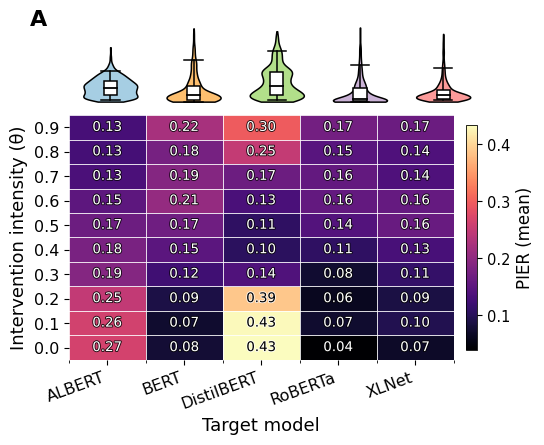

In [18]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe


# =========================
# Input
# =========================
path = DATA_PATH  # <- change if needed
df = pd.read_csv(path)

def parse_theta(s: str) -> float:
    s = str(s)
    m = re.search(r"theta=([0-9.]+)", s)
    if m:
        return float(m.group(1))
    m = re.search(r"θ=([0-9.]+)", s)
    return float(m.group(1)) if m else np.nan

df["theta"] = df["Eval_Point"].apply(parse_theta)

# Uniqueness columns like: ALBERT_Uniqueness_R, ...
uniq_cols = [c for c in df.columns if c.endswith("_Uniqueness_R")]

long = df.melt(
    id_vars=["theta"],
    value_vars=uniq_cols,
    var_name="model",
    value_name="uniqueness",
)
long["model"] = long["model"].str.replace("_Uniqueness_R", "", regex=False)

# Heatmap values (mean across samples)
heat = (
    long.groupby(["theta", "model"])["uniqueness"]
        .mean()
        .unstack("model")
        .reindex(sorted(long["theta"].unique()))
)
thetas = heat.index.values
models = heat.columns.tolist()

# =========================
# Nature-ish styling (bigger fonts for multi-panel)
# =========================
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 13,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# =========================
# Figure layout (square)
# =========================
fig = plt.figure(figsize=(5.2, 4.8))  # square
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1.4, 4.2], hspace=0.06)

ax_top = fig.add_subplot(gs[0, 0])
ax_main = fig.add_subplot(gs[1, 0])   


# =========================
# Heatmap
# =========================
cmap = "magma"
im = ax_main.imshow(
    heat.values,
    aspect="auto",
    origin="lower",
    cmap=cmap,
    interpolation="nearest",
)

ax_main.set_yticks(np.arange(len(thetas)))
ax_main.set_yticklabels([f"{t:.1f}" for t in thetas])

ax_main.set_xlabel("Target model")
ax_main.set_ylabel("Intervention intensity (θ)")

# subtle gridlines (optional)
ax_main.set_xticks(np.arange(-.5, len(models), 1), minor=True)
ax_main.set_yticks(np.arange(-.5, len(thetas), 1), minor=True)
ax_main.grid(which="minor", color="white", linewidth=0.6, alpha=1.0)
ax_main.tick_params(which="minor", bottom=False, left=False)

ax_main.spines["left"].set_visible(False)
ax_main.spines["bottom"].set_visible(False)



cbar = fig.colorbar(
    im,
    ax=ax_main,
    location="right",   
    pad=0.03,           
    fraction=0.045,     
    shrink=0.92         
)
cbar.set_label("PIER (mean)", fontsize=12)
cbar.ax.tick_params(labelsize=10.5)
cbar.outline.set_linewidth(0.6)


# =========================
# Annotate heatmap cells (numbers)
# =========================
vals = heat.values
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        v = vals[i, j]
        if np.isnan(v):
            continue

        # choose text color based on background luminance
        r, g, b, _ = im.cmap(im.norm(v))
        lum = 0.2126 * r + 0.7152 * g + 0.0722 * b
        txt_color = "black" if lum > 0.60 else "white"
        outline = "white" if txt_color == "black" else "black"

        t = ax_main.text(
            j, i, f"{v:.2f}",
            ha="center", va="center",
            fontsize=9.6,
            color=txt_color,
            zorder=10
        )
        # subtle outline for readability
        t.set_path_effects([pe.withStroke(linewidth=1.3, foreground=outline, alpha=0.85)])


# =========================
# Top violins (outlined + inner box, like your example)
# =========================
positions = np.arange(len(models))
data_by_model = [
    long.loc[long["model"] == m, "uniqueness"].dropna().values
    for m in models
]

# Muted pastel fills (edit if you prefer grayscale)
violin_colors = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#FB9A99"]

parts = ax_top.violinplot(
    data_by_model,
    positions=positions,
    widths=0.65,
    showmeans=False,
    showextrema=False,
    showmedians=False
)

# violin body styling
for i, body in enumerate(parts["bodies"]):
    body.set_facecolor(violin_colors[i % len(violin_colors)])
    body.set_edgecolor("black")
    body.set_linewidth(1.1)
    body.set_alpha(1.0)

# inner box + median + whiskers (robust: 5th-95th)
box_w = 0.16
cap_w = 0.22
for x, vals in zip(positions, data_by_model):
    if len(vals) == 0:
        continue
    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    wlow, whigh = np.percentile(vals, [5, 95])

    # whisker line + caps
    ax_top.plot([x, x], [wlow, whigh], color="black", linewidth=1.1, zorder=3)
    ax_top.plot([x - cap_w/2, x + cap_w/2], [wlow, wlow], color="black", linewidth=1.1, zorder=3)
    ax_top.plot([x - cap_w/2, x + cap_w/2], [whigh, whigh], color="black", linewidth=1.1, zorder=3)

    # IQR box
    rect = Rectangle(
        (x - box_w/2, q1),
        box_w,
        q3 - q1,
        facecolor="white",
        edgecolor="black",
        linewidth=1.1,
        zorder=4
    )
    ax_top.add_patch(rect)

    # median line
    ax_top.plot([x - box_w/2, x + box_w/2], [med, med],
                color="black", linewidth=1.3, zorder=5)

ax_top.set_xlim(-0.5, len(models) - 0.5)

ax_top.set_xlim(-0.5, len(models) - 0.5)
ax_main.set_xlim(-0.5, len(models) - 0.5)

ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

ticks = np.arange(len(models))
ax_main.set_xticks(ticks)
ax_main.set_xticklabels(models, rotation=20, ha="right")
ax_main.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

ax_top.set_xticks([])
ax_top.set_yticks([])

# Panel label
ax_top.text(-0.10, 1.35, "A", transform=ax_main.transAxes,
             fontsize=16, fontweight="bold", va="bottom")

# clean top axis
for spine in ax_top.spines.values():
    spine.set_visible(False)
    
# manual layout: maximize subplot area (Nature-like)
fig.subplots_adjust(left=0.18, right=0.98, bottom=0.18, top=0.88, wspace=0.28)

# =========================
# Save
# =========================
plt.savefig(os.path.join(FIG_PATH, "heatmap_top_violin_nature_square_bigfont.pdf"), bbox_inches=None)
plt.show()


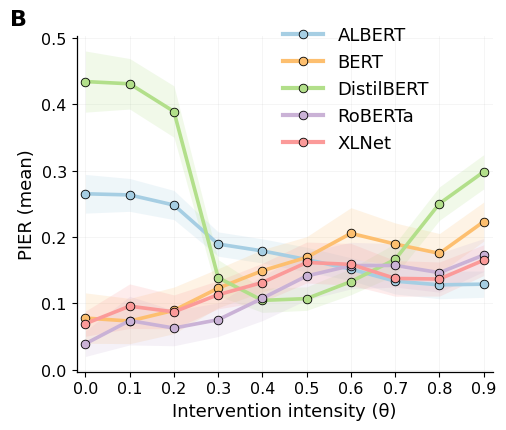

In [15]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- load ----
path = DATA_PATH  
df = pd.read_csv(path)

def parse_theta(s: str) -> float:
    s = str(s)
    m = re.search(r"theta=([0-9.]+)", s)
    if m:
        return float(m.group(1))
    m = re.search(r"θ=([0-9.]+)", s)
    return float(m.group(1)) if m else np.nan

df["theta"] = df["Eval_Point"].apply(parse_theta)

uniq_cols = [c for c in df.columns if c.endswith("_Uniqueness_R")]
long = df.melt(id_vars=["theta"], value_vars=uniq_cols, var_name="model", value_name="uniqueness")
long["model"] = long["model"].str.replace("_Uniqueness_R", "", regex=False)

# Model order consistent with heatmap pivot columns
heat = (long.groupby(["theta", "model"])["uniqueness"].mean().unstack("model").reindex(sorted(long["theta"].unique())))
models = heat.columns.tolist()
thetas = heat.index.values

# Same palette as violins (repeat if more models)
base_colors = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#FB9A99"]
color_map = {m: base_colors[i % len(base_colors)] for i, m in enumerate(models)}

# Summary stats per (model, theta)
grp = long.groupby(["model", "theta"])["uniqueness"]
summary = grp.agg(
    mean="mean",
    q25=lambda x: np.quantile(x, 0.25),
    q75=lambda x: np.quantile(x, 0.75),
    std="std",
    n="count",
).reset_index()
summary["sem"] = summary["std"] / np.sqrt(summary["n"].clip(lower=1))

# ---- Styling (match your heatmap panel) ----
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 13,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, ax = plt.subplots(figsize=(5.2, 4.8))  # same size as heatmap

# subtle grid
ax.grid(True, which="major", linewidth=0.6, alpha=0.15)
ax.set_axisbelow(True)

for m in models:
    sub = summary[summary["model"] == m].sort_values("theta")
    x = sub["theta"].values
    y = sub["mean"].values
    lo = (sub["mean"] - 1.96*sub["sem"]).values
    hi = (sub["mean"] + 1.96*sub["sem"]).values

    # IQR ribbon
    ax.fill_between(x, lo, hi, alpha=0.18, linewidth=0, color=color_map[m], zorder=1)

    # line + markers
    ax.plot(
        x, y,
        linewidth=2.6,
        marker="o",
        markersize=6.2,
        color=color_map[m],
        markeredgecolor="black",
        markeredgewidth=0.6,
        label=m,
        zorder=3
    )

ax.set_xlabel("Intervention intensity (θ)")
ax.set_ylabel("PIER (mean)")
ax.set_xticks(thetas)
ax.set_xlim(thetas.min() - 0.02, thetas.max() + 0.02)

# legend (inside, clean)
leg = ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.48, 1.05), borderaxespad=0.0, handlelength=2.2)
for lh in leg.legend_handles:
    lh.set_linewidth(3.0)

# panel label (optional)
ax.text(-0.16, 1.02, "B", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

# manual layout: maximize subplot area (Nature-like)
fig.subplots_adjust(left=0.18, right=0.98, bottom=0.18, top=0.88, wspace=0.28)

plt.savefig(os.path.join(FIG_PATH, "dose_curves_nature_style_square.pdf"), bbox_inches=None)
plt.show()
